In [27]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [28]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [29]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [80]:
series_df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [63]:
series_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(7)
memory usage: 126.7 MB


In [64]:
series = series_df.query('dt > "2007-01-01 00:00:00" and dt < "2007-02-01 00:00:00"')

In [67]:
series = series['Global_active_power']

In [72]:
series = series.dropna()

Results of Dickey-Fuller Test:
Test Statistic                -1.196410e+01
p-value                        4.038191e-22
#Lags Used                     5.600000e+01
Number of Observations Used    4.458000e+04
Critical Value (1%)           -3.430497e+00
Critical Value (5%)           -2.861605e+00
Critical Value (10%)          -2.566805e+00
dtype: float64


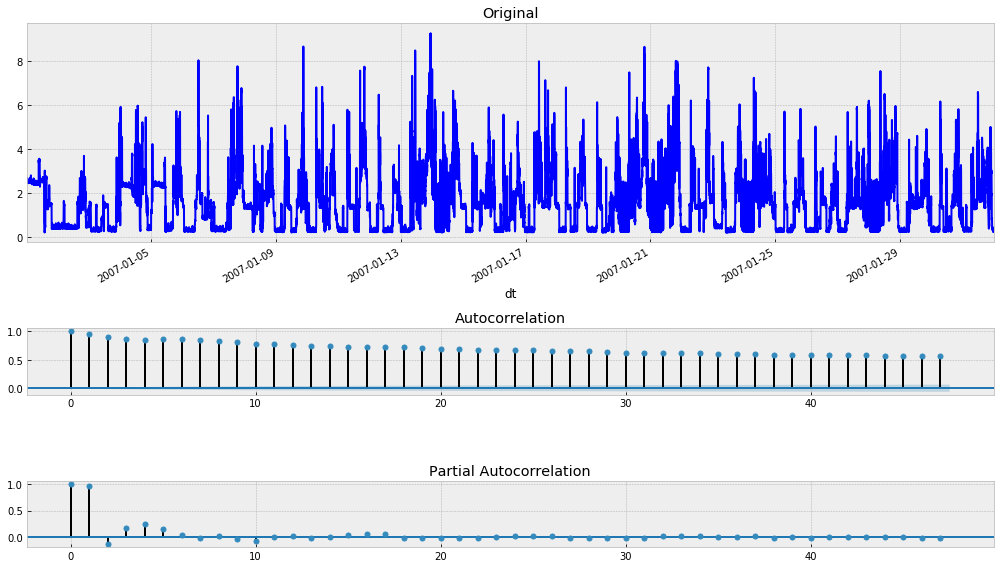

In [73]:
tsplot(series)

Как мы видим, и тест Дики-Фуллера и графики коррелограмм не отвергают гипотезу о нестационарности ряда. Для начала уберем изменение дисперсии при помощи преобразования Бокса-Кокса

In [74]:
series = boxcox(series, 0)

Results of Dickey-Fuller Test:
Test Statistic                -1.085288e+01
p-value                        1.513118e-19
#Lags Used                     5.600000e+01
Number of Observations Used    4.458000e+04
Critical Value (1%)           -3.430497e+00
Critical Value (5%)           -2.861605e+00
Critical Value (10%)          -2.566805e+00
dtype: float64


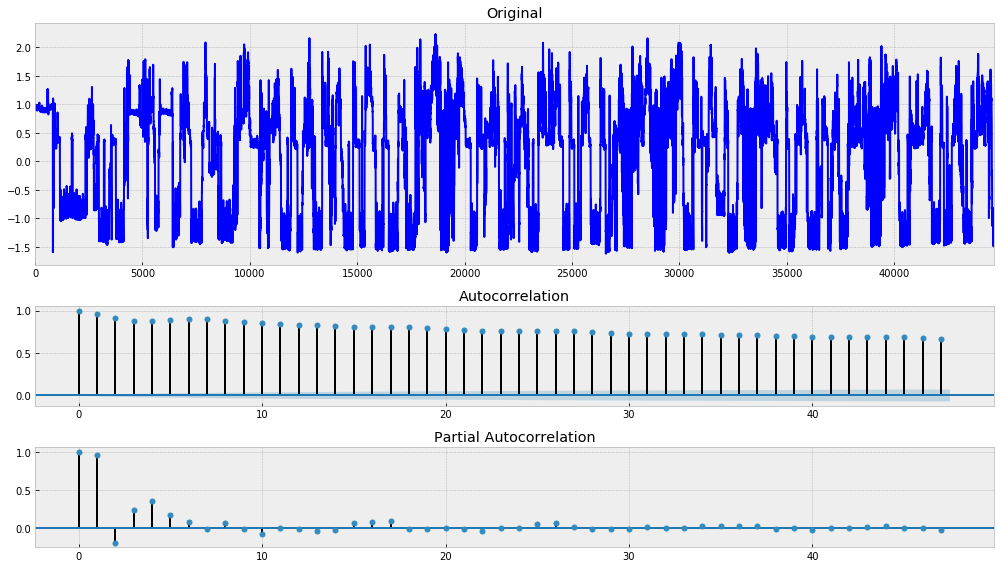

In [75]:
tsplot(series)

Нам удалось убрать размах дисперсии, но тест Дикки-Фуллера все еще не отвергает гипотезу о нестационарности ряда. По графику ряда видно наличие сильного тренда. Уберем его дифференцированием.

In [76]:
series = series[1:] - series[:-1]

Results of Dickey-Fuller Test:
Test Statistic                   -32.420717
p-value                            0.000000
#Lags Used                        56.000000
Number of Observations Used    44579.000000
Critical Value (1%)               -3.430497
Critical Value (5%)               -2.861605
Critical Value (10%)              -2.566805
dtype: float64


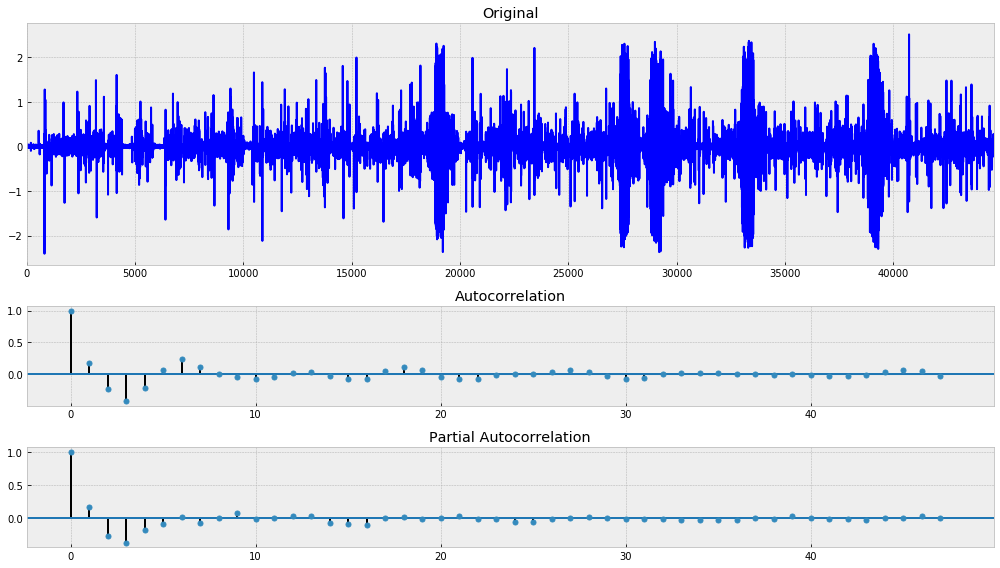

In [77]:
tsplot(series)

Стало еще лучше, но по графику коррелограммы видно сильное влияние сезонности. Уберем ее

In [78]:
series = series[12:] - series[:-12]

Results of Dickey-Fuller Test:
Test Statistic                   -44.302949
p-value                            0.000000
#Lags Used                        56.000000
Number of Observations Used    44567.000000
Critical Value (1%)               -3.430497
Critical Value (5%)               -2.861605
Critical Value (10%)              -2.566805
dtype: float64


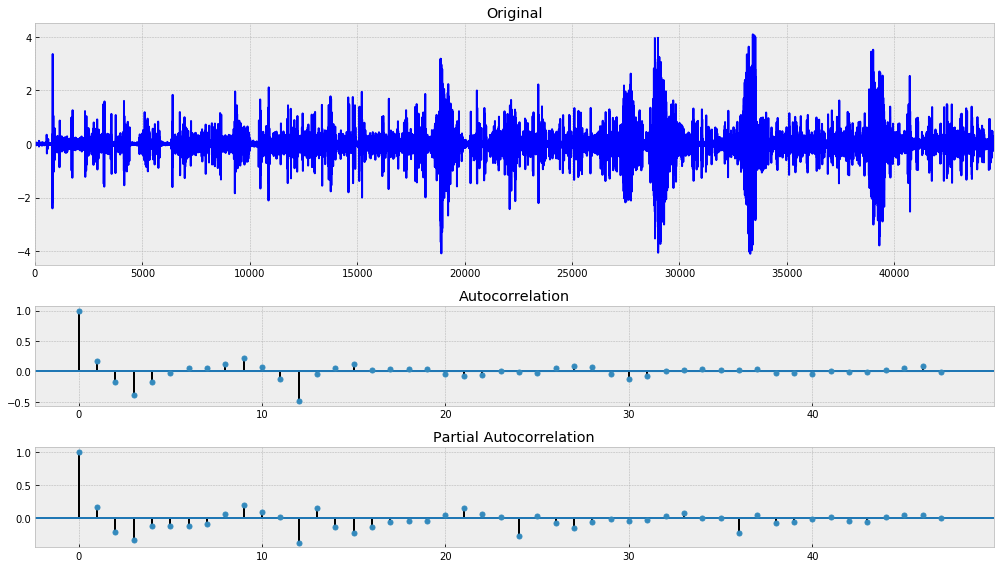

In [79]:
tsplot(series)

Теперь тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда!